### **Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### **Format Prices**

In [2]:
price_df = pd.read_csv('price_demand_data.csv')
date = pd.to_datetime(price_df.SETTLEMENTDATE,format='%Y-%m-%d %H:%M:%S')
price_df.insert(0,'Date', [str(d.strftime("%Y-%m-%-d")) for d in date], True)
price_df.insert(1, 'Time', [str(d.time()) for d in date])
price_df.drop(['SETTLEMENTDATE', 'PRICESURGE'], axis=1, inplace=True)
price_df.rename(columns={'REGION': 'Region', 'TOTALDEMAND': 'Demand'}, inplace=True)

price_df.head(5)

,Date,Time,Region,Demand
0,2021-02-1,00:30:00,NSW1,6693.67
1,2021-02-1,01:00:00,NSW1,6511.88
2,2021-02-1,01:30:00,NSW1,6275.03
3,2021-02-1,02:00:00,NSW1,6121.26
4,2021-02-1,02:30:00,NSW1,6123.13


#### **Dataset Description**

In [3]:
adelaide_df = pd.read_csv("weather_adelaide.csv")
brisbane_df = pd.read_csv("weather_brisbane.csv")
melbourne_df = pd.read_csv("weather_melbourne.csv")
sydney_df = pd.read_csv("weather_sydney.csv")

# adelaide_df.head(5)

#### **Correlation Analysis - Feature Checking**

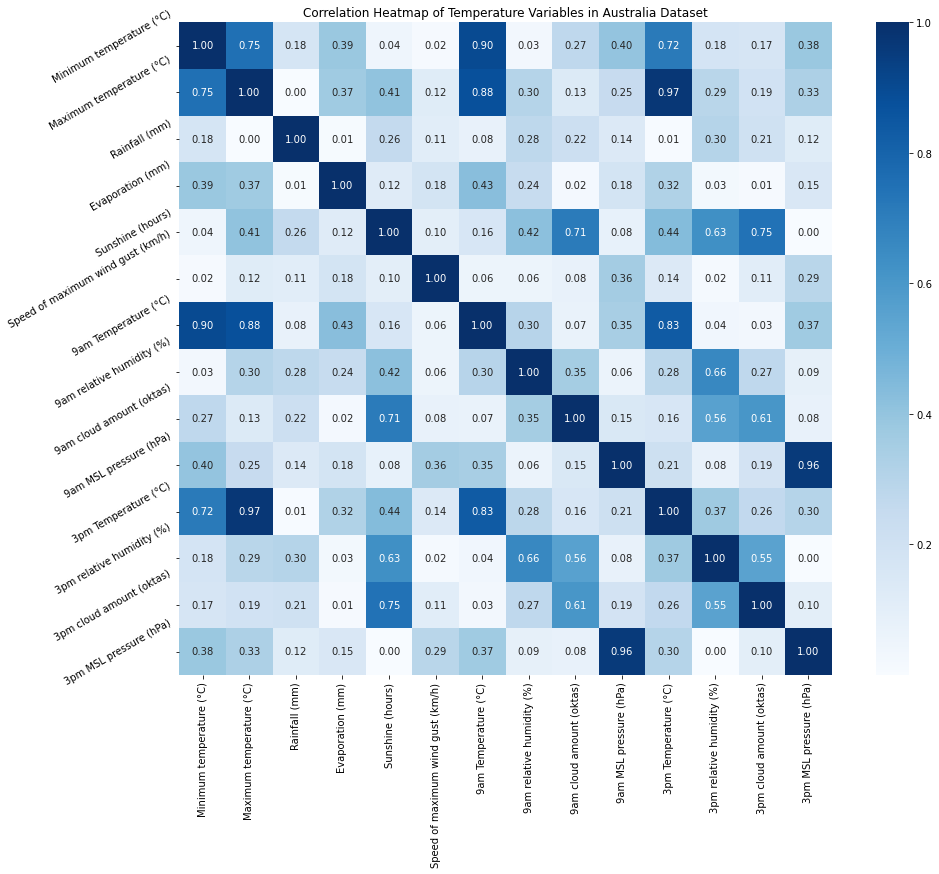

In [4]:
correlation = abs(pd.concat([adelaide_df, brisbane_df, melbourne_df, sydney_df]).corr())

plt.figure(figsize=(16,12))
plt.title('Correlation Heatmap of Temperature Variables in Australia Dataset')
ax = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', cmap="Blues")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)           
plt.savefig('graphs/varcorr.png')
plt.show()

### **Import, Clean, Merge Weather Data**

In [5]:
from IPython.display import display

def merge(state_df, state_code, price_df, time):
    if time == '9am':
        time_index = ('9am Temperature (°C)', '09:30:00')
    elif time == '3pm':
        time_index = ('3pm Temperature (°C)', '15:30:00')
        
    temp_df = state_df[['Date', time_index[0]]]
    filtered_df = price_df[(price_df['Time'] == time_index[1]) & (price_df['Region'] == state_code)].copy() 
    
    merged_df = pd.merge(temp_df, filtered_df, on='Date', how='inner')
    merged_df.rename(columns={time_index[0]: 'Temperature'}, inplace=True)
    merged_df.dropna(inplace=True)
    
    return merged_df

adelaide_9am = merge(adelaide_df, 'SA1', price_df, '9am')
adelaide_3pm = merge(adelaide_df, 'SA1', price_df, '3pm')
brisbane_9am = merge(brisbane_df, 'QLD1', price_df, '9am')
brisbane_3pm = merge(brisbane_df, 'QLD1', price_df, '3pm')
melbourne_9am = merge(melbourne_df, 'VIC1', price_df, '9am')
melbourne_3pm = merge(melbourne_df, 'VIC1', price_df, '3pm')
sydney_9am = merge(melbourne_df, 'NSW1', price_df, '9am')
sydney_3pm = merge(melbourne_df, 'NSW1', price_df, '3pm')


### **Data Exploration**

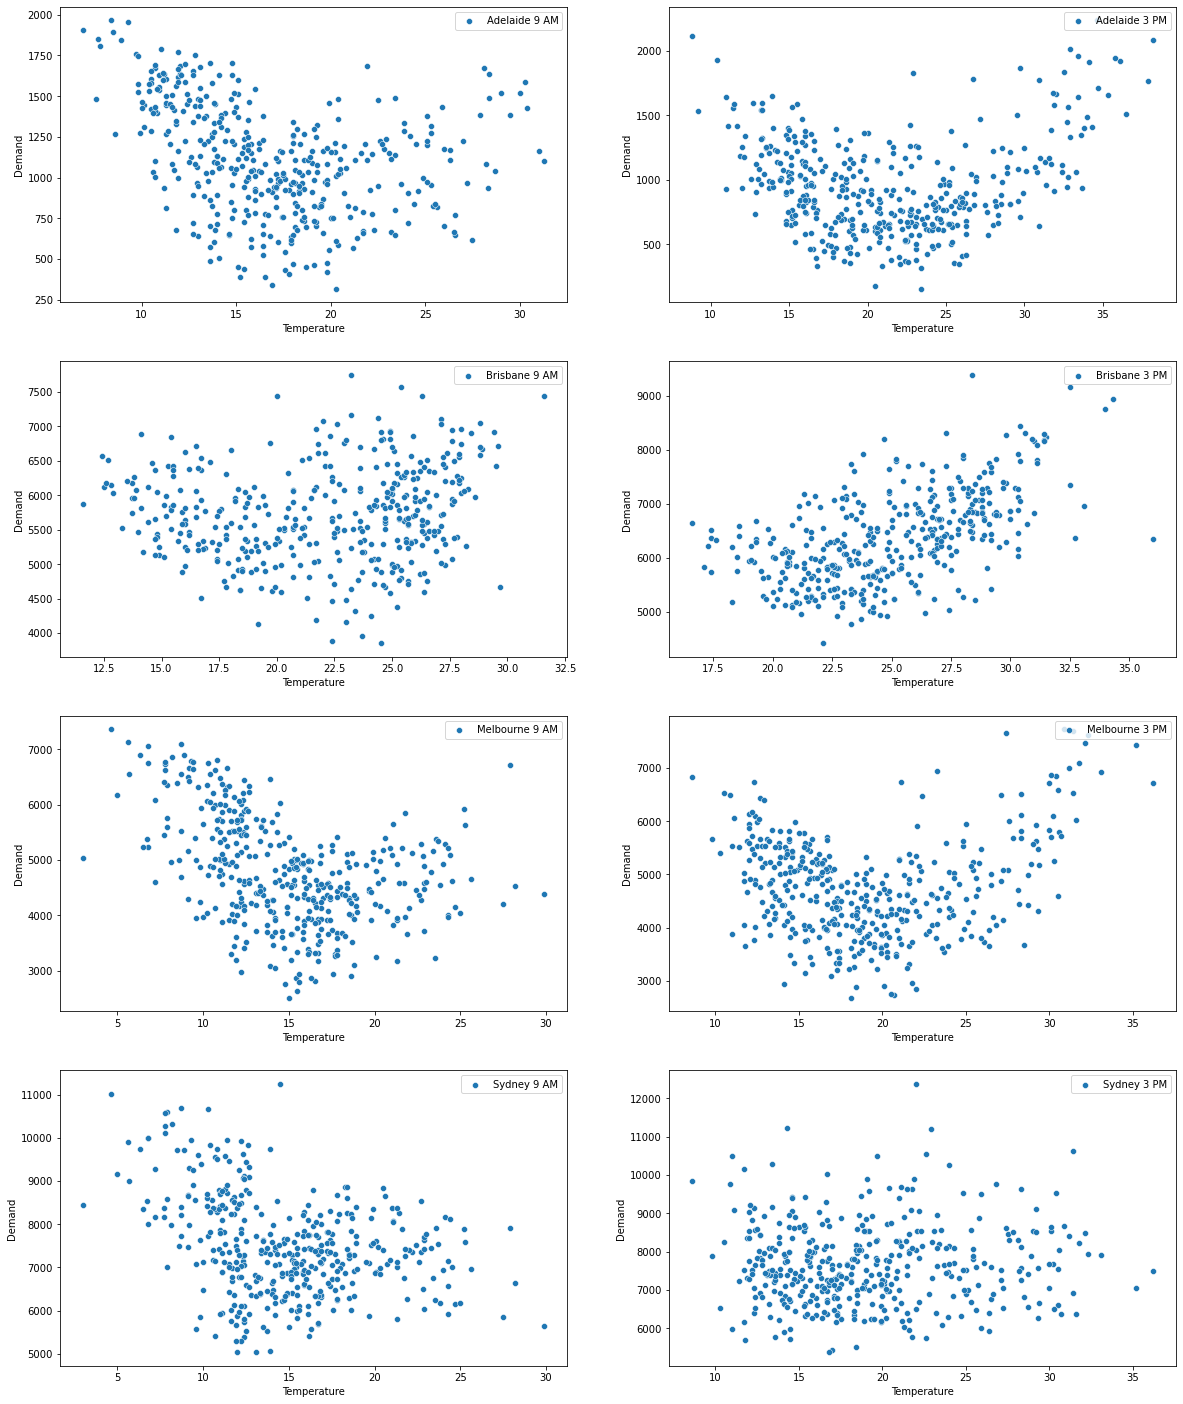

In [6]:
demand_files = [adelaide_9am, adelaide_3pm, brisbane_9am, brisbane_3pm, melbourne_9am, melbourne_3pm, sydney_9am, sydney_3pm]
city = ['Adelaide','Brisbane','Melbourne','Sydney']
times = ['9 AM', '3 PM']

fig, ax = plt.subplots(4, 2, figsize=(20, 25))

for c in city:
    for t in times:
        if t == '9 AM':
            sns.scatterplot(x='Temperature', y='Demand', data=demand_files[2*city.index(c)], ax=ax[city.index(c), 0], label=(f'{c} {t}'))
            ax[city.index(c), 0].legend(loc='upper right')
        elif t == '3 PM':
            sns.scatterplot(x='Temperature', y='Demand', data=demand_files[2*city.index(c) + 1], ax=ax[city.index(c), 1], label=(f'{c} {t}'))
            ax[city.index(c), 1].legend(loc='upper right')


### **Testing Linear Regression**

'Adelaide 9 AM 5Fold CV R2: 0.07167 | RMSE: 320.37'

'Adelaide 3 PM 5Fold CV R2: -0.02251 | RMSE: 355.68'

'Brisbane 9 AM 5Fold CV R2: -0.02609 | RMSE: 675.85'

'Brisbane 3 PM 5Fold CV R2: 0.30181 | RMSE: 683.56'

'Melbourne 9 AM 5Fold CV R2: 0.16504 | RMSE: 901.06'

'Melbourne 3 PM 5Fold CV R2: -0.04731 | RMSE: 952.56'

'Sydney 9 AM 5Fold CV R2: 0.14673 | RMSE: 1061.35'

'Sydney 3 PM 5Fold CV R2: -0.01464 | RMSE: 1047.31'

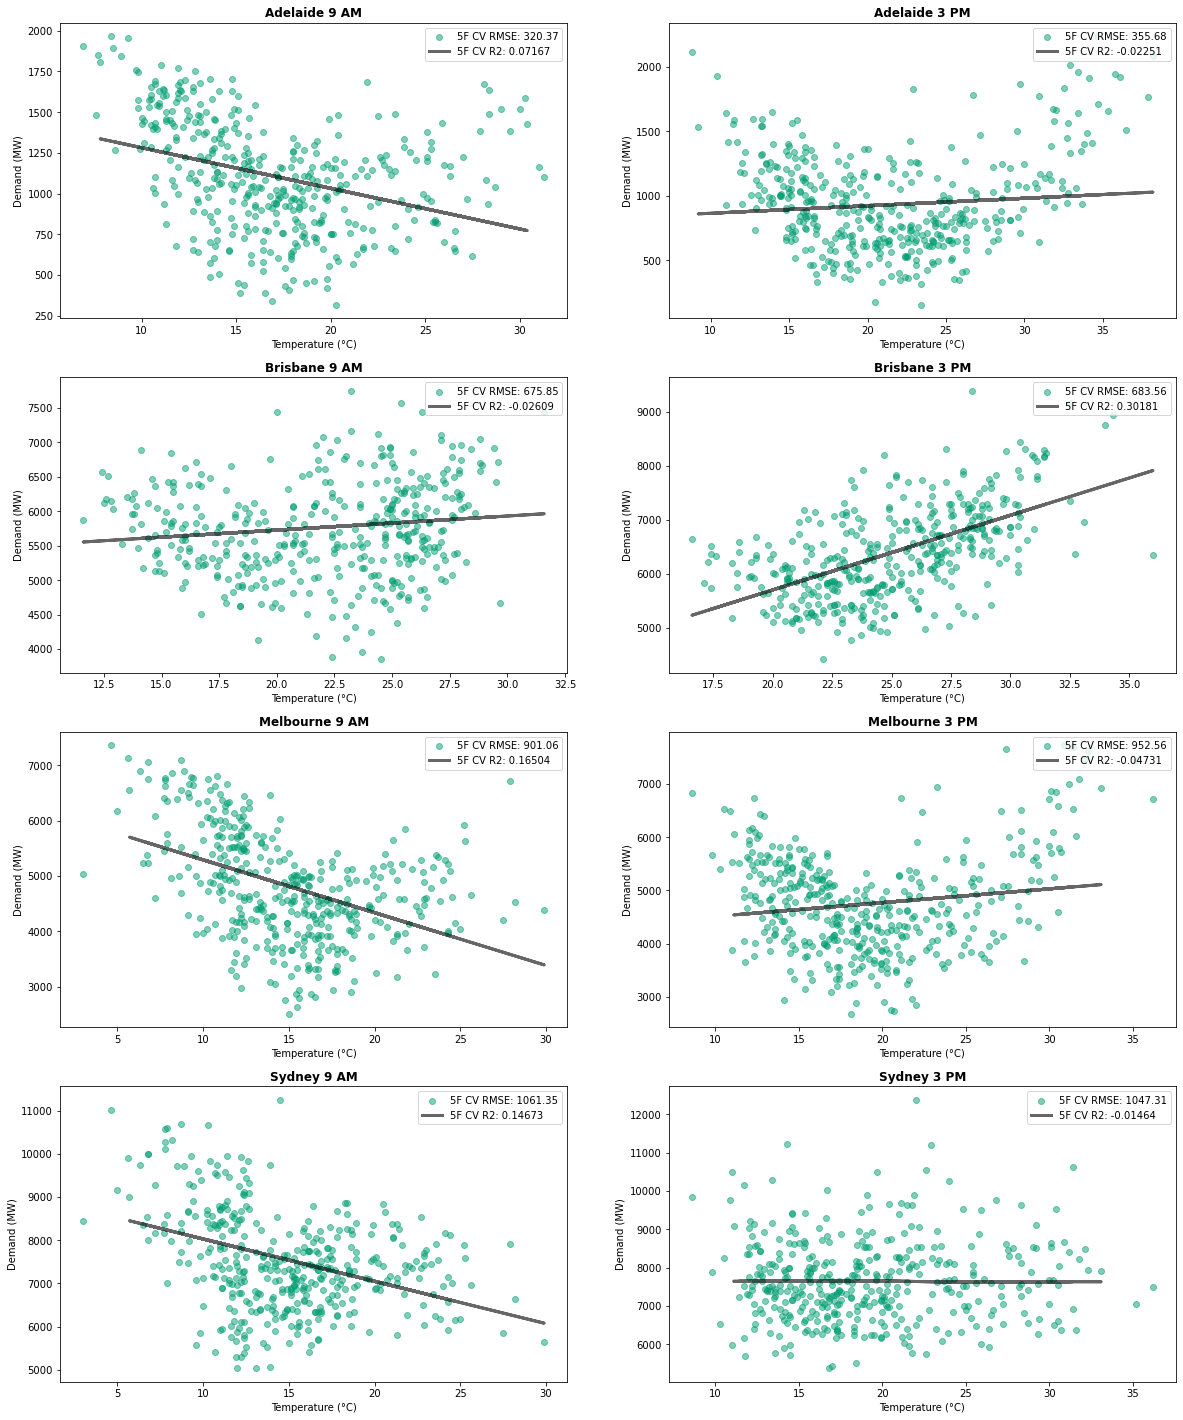

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

fig, ax = plt.subplots(4, 2, figsize=(20, 25))

demand_files = [adelaide_9am, adelaide_3pm, brisbane_9am, brisbane_3pm, melbourne_9am, melbourne_3pm, sydney_9am, sydney_3pm]
city = ['Adelaide','Brisbane','Melbourne','Sydney']
times = ['9 AM', '3 PM']


for c in city:
    for t in times:
      X = demand_files[2*city.index(c) + times.index(t)]['Temperature'].values.reshape(-1, 1)
      y = demand_files[2*city.index(c) + times.index(t)]['Demand'].values
      
      X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=1)

      model = LinearRegression().fit(X_train, Y_train)

      Y_pred = model.predict(X_test)
      
      cve = cross_validate(model, X_train , Y_train, scoring=['neg_root_mean_squared_error','r2'], cv=5, return_train_score=True)
      rmse = np.absolute(cve["test_neg_root_mean_squared_error"]).mean()
      r2 = cve["test_r2"].mean()
      
      display(f'{c} {t} 5Fold CV R2: {r2:.5f} | RMSE: {rmse:.2f}')

      ax[city.index(c),times.index(t)].scatter(X, y, color='#009E73', label=f'5F CV RMSE: {rmse:.2f}', alpha=0.5)
      ax[city.index(c),times.index(t)].plot(X_test, Y_pred, color="black", label=f'5F CV R2: {r2:.5f}', linewidth=3, alpha=0.6)
      ax[city.index(c),times.index(t)].set_xlabel('Temperature (°C)')
      ax[city.index(c),times.index(t)].set_ylabel('Demand (MW)')
      ax[city.index(c),times.index(t)].set_title(f'{c} {t}', fontweight='bold')
      ax[city.index(c),times.index(t)].legend(loc='upper right')

plt.savefig('graphs/linreg.png')
plt.show()

### **Testing Polynomial Regression**

'Adelaide 9 AM 5Fold CV R2: 0.30419 | RMSE: 275.51'

'Adelaide 3 PM 5Fold CV R2: 0.38682 | RMSE: 274.38'

'Brisbane 9 AM 5Fold CV R2: 0.03549 | RMSE: 656.07'

'Brisbane 3 PM 5Fold CV R2: 0.34133 | RMSE: 663.29'

'Melbourne 9 AM 5Fold CV R2: 0.32671 | RMSE: 809.44'

'Melbourne 3 PM 5Fold CV R2: 0.32056 | RMSE: 767.38'

'Sydney 9 AM 5Fold CV R2: 0.22435 | RMSE: 1010.85'

'Sydney 3 PM 5Fold CV R2: -0.00438 | RMSE: 1041.85'

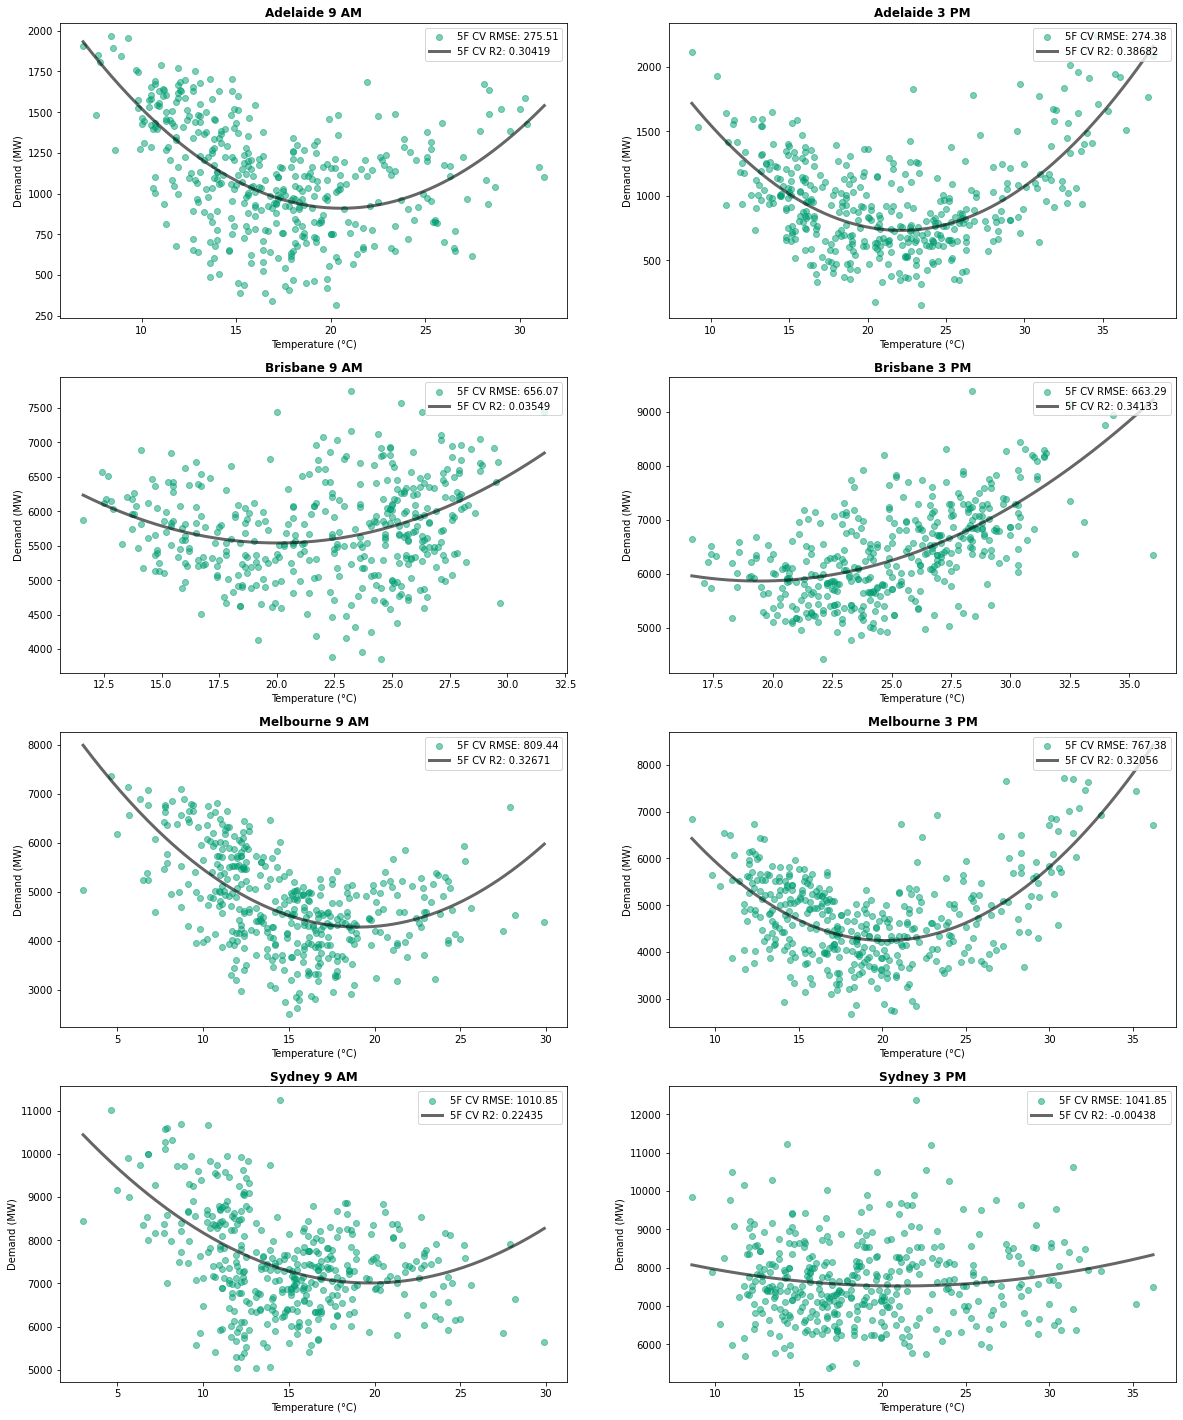

In [8]:
from sklearn.preprocessing import PolynomialFeatures

fig, ax = plt.subplots(4, 2, figsize=(20, 25))

demand_files = [adelaide_9am, adelaide_3pm, brisbane_9am, brisbane_3pm, melbourne_9am, melbourne_3pm, sydney_9am, sydney_3pm]
city = ['Adelaide','Brisbane','Melbourne','Sydney']
times = ['9 AM', '3 PM']


for c in city:
    for t in times:
        X = demand_files[2*city.index(c) + times.index(t)]['Temperature'].values.reshape(-1, 1)
        y = demand_files[2*city.index(c) + times.index(t)]['Demand'].values
        
        X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=1)

        poly = PolynomialFeatures(degree=2, include_bias=True)
        
        X_train = poly.fit_transform(X_train)
        X_test = poly.transform(X_test)
        
        model = LinearRegression().fit(X_train, Y_train)

        Y_pred = model.predict(X_test)
        
        X_new = np.linspace(min(X), max(X), 200).reshape(200, 1)
        X_new_poly = poly.transform(X_new)
        y_new = model.predict(X_new_poly)
        
        cve = cross_validate(model, X_train , Y_train, scoring=['neg_root_mean_squared_error','r2'], cv=5, return_train_score=True)
        rmse = np.absolute(cve["test_neg_root_mean_squared_error"]).mean()
        r2 = cve["test_r2"].mean()
        
        display(f'{c} {t} 5Fold CV R2: {r2:.5f} | RMSE: {rmse:.2f}')

        ax[city.index(c),times.index(t)].scatter(X, y, color='#009E73', label=f'5F CV RMSE: {rmse:.2f}', alpha=0.5)
        ax[city.index(c),times.index(t)].plot(X_new, y_new, color="black", label=f'5F CV R2: {r2:.5f}', linewidth=3, alpha=0.6)
        ax[city.index(c),times.index(t)].set_xlabel('Temperature (°C)')
        ax[city.index(c),times.index(t)].set_ylabel('Demand (MW)')
        ax[city.index(c),times.index(t)].set_title(f'{c} {t}', fontweight='bold')
        ax[city.index(c),times.index(t)].legend(loc='upper right')

plt.savefig('graphs/polyreg.png')
plt.show()